# Non-Linear Geostatistics

This case study is meant to demonstrate how to use *gstlearn* for non-linear geostatistics.

In [1]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np

Global parameters

In [2]:
# Set the Seed for the Random Number generator
gl.law_set_random_seed(32131)

# Define the Space Dimension
ndim = 2
gl.ASpaceObject_defineDefaultSpace(gl.ESpaceType.SPACE_RN, ndim)

# Defining the format for dumping statistics of variables in a Db
dbfmt = gl.DbStringFormat()
dbfmt.setFlags(flag_resume=True,flag_vars=False,flag_locator=True)

# Defining global options
flagDebugCalculations = True
flagPerformGraphics = True

Setting the trace: this option alloes dumping all the elements to check calculations when the rank of the target is equal to 1 (first block, first panel, ...). This option is important for debugging but it creates lots of printout.

In [3]:
if flagDebugCalculations:
    gl.OptDbg_setReference(1)

Defining color scales common to all future representations of estimated quantities:

In [4]:
ZEstMin = -3.
ZEstMax = +3.
TEstMin = 0.
TEstMax = 1.
TStdMin = 0.
TStdMax = 1.
QEstMin = 0.
QEstMax = 3.
QStdMin = 0.
QStdMax = 2.

Generate initial grid

In [5]:
grid = gl.DbGrid.create([100,100], [0.01,0.01])
grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 3
Maximum Number of UIDs       = 3
Total number of samples      = 10000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.010     0.010
Number :        100       100

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
 

Create grid of Panels covering the entiere simulated area

In [6]:
dx_P = 0.25
panel = gl.DbGrid.createCoveringDb(grid,dcell=[dx_P,dx_P])

Discretization with a grid of blocks which cover the simulated area

In [7]:
nx_B = 5
dx_B = dx_P / nx_B
blocs = gl.DbGrid.createCoveringDb(grid,dcell=[dx_B,dx_B])
blocs.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 2
Maximum Number of UIDs       = 2
Total number of samples      = 441

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.050     0.050
Number :         21        21

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2
 

Simulation of the Data

In [8]:
model_init = gl.Model_createFromParam(gl.ECov.EXPONENTIAL, range=0.1, sill=1.)
gl.simtub(None, grid, model_init)
grid.setName("Simu", "Y")
grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 10000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.010     0.010
Number :        100       100

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Y - Locator = z1
 

Non-linear transform

In [9]:
m_Z = 1.5
s_Z = 0.5
Zval = np.array(grid.getColumn("Y"))
for i in range(grid.getSampleNumber()):
    Zval[i] = m_Z * np.exp(s_Z * Zval[i] - 0.5 * s_Z * s_Z)
iuid = grid.addColumns(Zval, "Z")

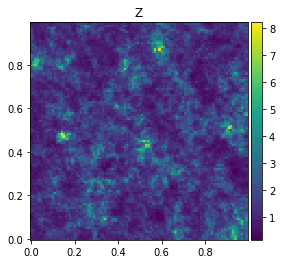

In [10]:
if flagPerformGraphics:
    ax = gp.grid(grid, name="Z")

Data extraction

In [11]:
np = 500
data = gl.Db_createSamplingDb(grid, number=np, names=["x1","x2","Y","Z"])
data.setLocator("Z", gl.ELoc.Z)
data.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 500

List of unsorted UIDs
---------------------
Maximum number of positions = 4
Number of Columns           = 4
UID = 0 1 2 3 


List of locators
----------------
1 - Locator: x
- Attributes = 0 1 
- Columns    = 0 1 
2 - Locator: z
- Attributes = 3 
- Columns    = 3 

 

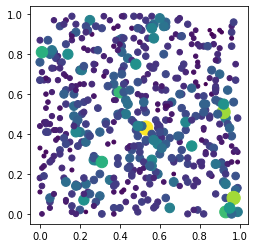

In [12]:
if flagPerformGraphics:
    ax = gp.point(data, color_name="Z", size_name="Z", flagColorBar=False, flagSizeLegend=False)

Gaussian Anamorphosis with 10 coefficients

In [13]:
anam = gl.AnamHermite.create(nbpoly=20)
anam.fit(data)
anam.display()


Hermitian Anamorphosis
----------------------
Minimum absolute value for Y  = -2.8
Maximum absolute value for Y  = 3.1
Minimum absolute value for Z  = 0.354599
Maximum absolute value for Z  = 7.05246
Minimum practical value for Y = -2.8
Maximum practical value for Y = 3.1
Minimum practical value for Z = 0.354599
Maximum practical value for Z = 7.05246
Mean                          = 1.56826
Variance                      = 0.709296
Number of Hermite polynomials = 20
Normalized coefficients for Hermite polynomials
               [,  0]    [,  1]    [,  2]    [,  3]    [,  4]    [,  5]    [,  6]
     [  0,]     1.568    -0.782     0.292    -0.086     0.018     0.016    -0.033
     [  7,]     0.025     0.001    -0.022     0.018     0.004    -0.019     0.011
     [ 14,]     0.011    -0.016    -0.002     0.015    -0.005    -0.010
 

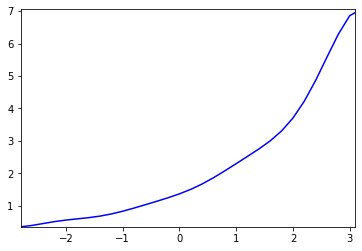

In [14]:
if flagPerformGraphics:
    ax = gp.anam(anam)

Selectivity: We focus on Tonnage (T) and Metal Quantity (Q) for 2 cutoffs (0 and 0.5)

In [15]:
selectivity = gl.Selectivity_createByCodes([gl.ESelectivity.Q, gl.ESelectivity.T], zcuts=[0., 0.5], 
                                           flag_est=True, flag_std=True)

Global experimental selectivity, calculated form the experimental Data Set

In [16]:
selectivity.eval(data)


Table contents
--------------
- Number of Rows    = 2
- Number of Columns = 7

      Z-Cut      T-Est      Q-Est      B-Est      M-Est      T-Std      Q-Std
      0.000      1.000      1.568      1.568      1.568        N/A        N/A
      0.500      0.988      1.563      1.069      1.582        N/A        N/A

Selectivity in the model, derived from the parameters contained in the Anamorphosis

In [17]:
selectivity.eval(anam)


Table contents
--------------
- Number of Rows    = 2
- Number of Columns = 7

      Z-Cut      T-Est      Q-Est      B-Est      M-Est      T-Std      Q-Std
      0.000      1.000      1.568      1.568      1.568        N/A        N/A
      0.500      0.988      1.563      1.069      1.582        N/A        N/A

Define the variogram calculation parameters: omni-directional variogram calculated in 2-D pace, with 10 lags of 0.025.

In [18]:
varioparam = gl.VarioParam_createOmniDirection(ndim=ndim, npas=10, dpas=0.025)

Calculate the variogram of the raw variable

In [19]:
vario_raw = gl.Vario_computeFromDb(varioparam, db=data)

Fitting the Model on the Raw variable

In [20]:
model_raw = gl.Model_createFromEnvironment(nvar=1, ndim=ndim)
model_raw.fit(vario_raw)
model_raw.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Spherical
- Sill         =      0.673
- Range        =      0.076
Total Sill     =      0.673
 

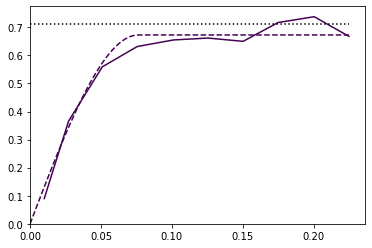

In [21]:
if flagPerformGraphics:
    ax = gp.varmod(vario_raw, model_raw)

Transform Data into Gaussian variable

In [22]:
gl.RawToGaussianByLocator(data, anam=anam)
data.setName("Y.Z","Gauss.Z")
data.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 500

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2
Column = 2 - Name = Y - Locator = NA
Column = 3 - Name = Z - Locator = NA
Column = 4 - Name = Gauss.Z - Locator = z1
 

Calculate the variogram of the Gaussian variable

In [23]:
vario = gl.Vario_computeFromDb(varioparam, data)

Fitting the Model on the Gaussian transformed variable (under the constraint that the sill must be equal to 1)

In [24]:
model = gl.Model(1, ndim)
constraints = gl.Constraints(1.)
model.fit(vario, [gl.ECov.EXPONENTIAL, gl.ECov.EXPONENTIAL], 
          mauto=gl.Option_AutoFit(), constraints=constraints)
model


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Exponential
- Sill         =      0.829
- Range        =      0.101
- Theo. Range  =      0.034
Exponential
- Sill         =      0.171
- Range        =      0.273
- Theo. Range  =      0.091
Total Sill     =      1.000

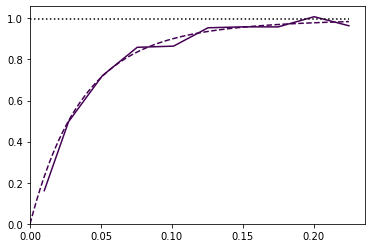

In [25]:
if flagPerformGraphics:
    ax = gp.varmod(vario, model)

Creating a Moving Neighborhood

In [26]:
nmini = 5
nmaxi = 5
radius = 1.
neigh = gl.NeighMoving_create(ndim=ndim, nmaxi=nmaxi, radius=radius, nmini=nmini)
neigh


Moving Neighborhood
Space dimension = 2
Minimum number of samples           = 5
Maximum number of samples           = 5
Maximum horizontal distance         = 1

## ====== Conditional Expectation ======

Estimating the Gaussian Variable on the nodes of the Blocks

In [27]:
data.setLocator("Gauss.Z",gl.ELoc.Z)
dummy = gl.kriging(data, blocs, model, neigh, calcul=gl.EKrigOpt.PONCTUAL,
        namconv=gl.NamingConvention("G_PTS"))


 Target location
 ---------------
 Sample #1 (from 441)
 Coordinate #1 = 0.000000
 Coordinate #2 = 0.000000
 
 Data selected in neighborhood
 -----------------------------
        Rank      Sample          x1          x2      Sector 
           1          23       0.000       0.110           1 
           2         222       0.050       0.060           1 
           3         310       0.050       0.080           1 
           4         400       0.010       0.000           1 
           5         481       0.050       0.030           1 
 
 LHS of Kriging matrix (compressed)
 Number of active samples    = 5
 Total number of equations   = 5
 Reduced number of equations = 5
 
        Rank                       1           2           3           4           5 
                    Flag           1           2           3           4           5 
           1           1       1.000       0.181       0.238       0.083       0.112 
           2           2       0.181       1.000       0.5

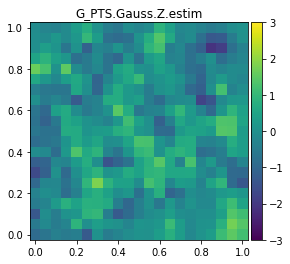

In [28]:
if flagPerformGraphics:
    ax = gp.grid(blocs, vmin=ZEstMin, vmax=ZEstMax)

Calculating the Conditional Expectation on blocks

In [29]:
dummy = gl.ConditionalExpectation(blocs, anam, selectivity, 
                                  name_est="G_PTS*estim", name_std="G_PTS*stdev", 
                                  namconv = gl.NamingConvention("PTS_Recovery", False))

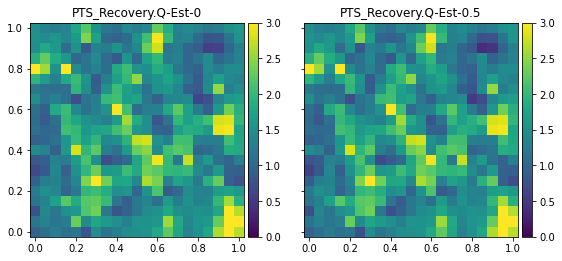

In [30]:
axs = gp.grids(blocs, "PTS_Recovery.Q-Est*",figsize=[9,9], vmin=QEstMin, vmax=QEstMax)

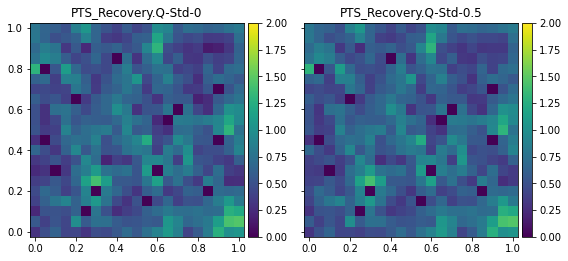

In [31]:
axs = gp.grids(blocs, "PTS_Recovery.Q-Std*",figsize=[9,9], vmin=QStdMin, vmax=QStdMax)

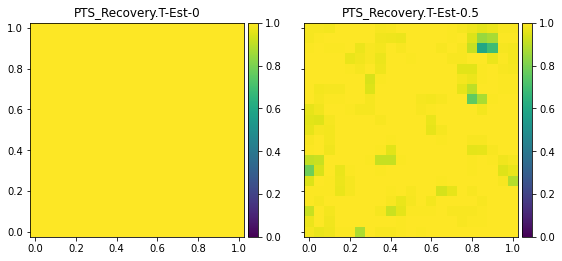

In [32]:
axs = gp.grids(blocs, "PTS_Recovery.T-Est*",figsize=[9,9], vmin=TEstMin, vmax=TEstMax)

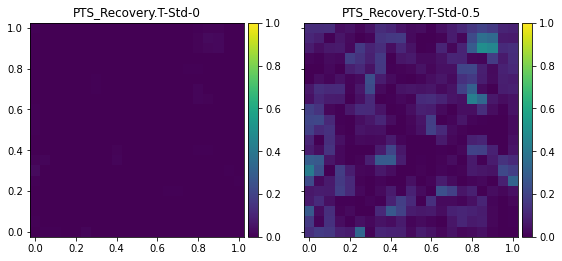

In [33]:
axs = gp.grids(blocs, "PTS_Recovery.T-Std*",figsize=[9,9], vmin=TStdMin, vmax=TStdMax)

## ====== Point Disjunctive Kriging ======

Attach the Anamorphosis to the Model

In [34]:
dummy = model.setAnam(anam)

Computing the Point factors

In [35]:
nfactor = 3
dummy = gl.RawToFactor(data, anam, nfactor)

Simple Point Kriging over the blocks

In [36]:
dummy = gl.DisjunctiveKriging(data, blocs, model, neigh, calcul=gl.EKrigOpt.PONCTUAL,
                              namconv = gl.NamingConvention("DK_Pts"))
blocs.display()


Processing Factor 1 / 3
 
 Target location
 ---------------
 Sample #1 (from 441)
 Coordinate #1 = 0.000000
 Coordinate #2 = 0.000000
 
 Data selected in neighborhood
 -----------------------------
        Rank      Sample          x1          x2      Sector 
           1          23       0.000       0.110           1 
           2         222       0.050       0.060           1 
           3         310       0.050       0.080           1 
           4         400       0.010       0.000           1 
           5         481       0.050       0.030           1 
 
 LHS of Kriging matrix (compressed)
 Number of active samples    = 5
 Total number of equations   = 5
 Reduced number of equations = 5
 
        Rank                       1           2           3           4           5 
                    Flag           1           2           3           4           5 
           1           1       1.000       0.181       0.238       0.083       0.112 
           2           2       0

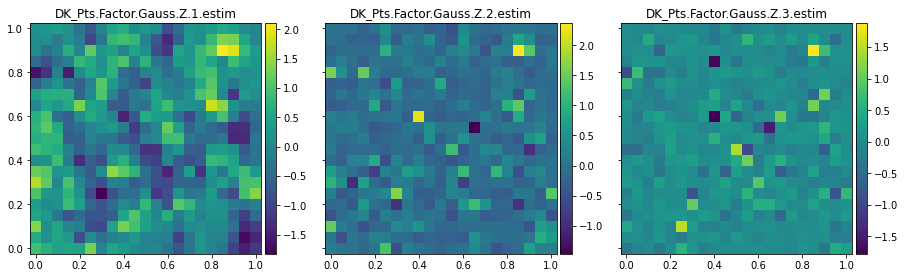

In [37]:
axs = gp.grids(blocs,names="DK_Pts*estim",figsize=[15,15])

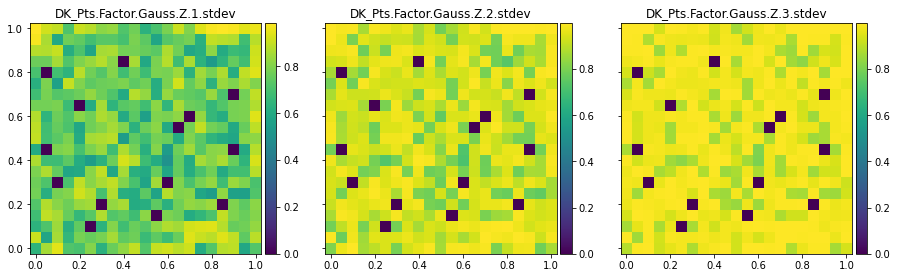

In [38]:
axs = gp.grids(blocs,names="DK_Pts*stdev",figsize=[15,15])

Simple Block Kriging over the blocks

In [39]:
ndisc_B = [5,5]
dummy = gl.DisjunctiveKriging(data, blocs, model, neigh, 
                              calcul=gl.EKrigOpt.BLOCK, ndisc=ndisc_B, 
                              namconv = gl.NamingConvention("DK_Blk"))
blocs.display()


Processing Factor 1 / 3
 
 Target location
 ---------------
 Sample #1 (from 441)
 Coordinate #1 = 0.000000
 Coordinate #2 = 0.000000
 
 Data selected in neighborhood
 -----------------------------
        Rank      Sample          x1          x2      Sector 
           1          23       0.000       0.110           1 
           2         222       0.050       0.060           1 
           3         310       0.050       0.080           1 
           4         400       0.010       0.000           1 
           5         481       0.050       0.030           1 
 
 LHS of Kriging matrix (compressed)
 Number of active samples    = 5
 Total number of equations   = 5
 Reduced number of equations = 5
 
        Rank                       1           2           3           4           5 
                    Flag           1           2           3           4           5 
           1           1       1.000       0.181       0.238       0.083       0.112 
           2           2       0

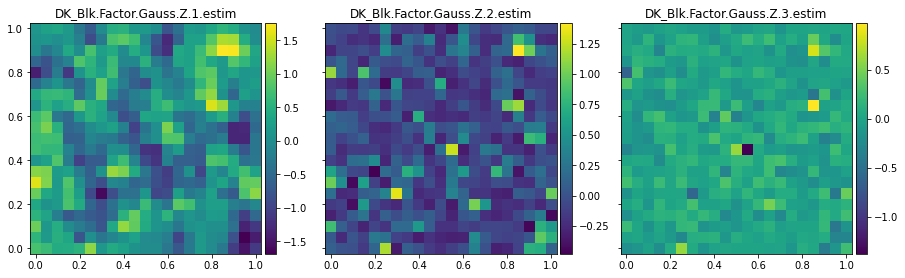

In [40]:
axs = gp.grids(blocs,names="DK_Blk*estim",figsize=[15,15])

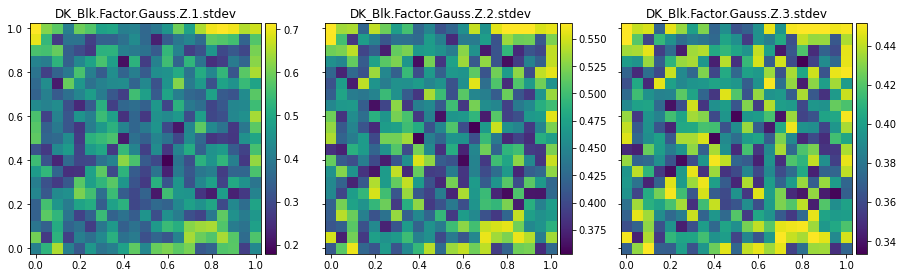

In [41]:
axs = gp.grids(blocs,names="DK_Blk*stdev",figsize=[15,15])

Comparing Point and Block estimations and standard deviation of Estimation errors (this comparison is performed on the results of the first factor only).

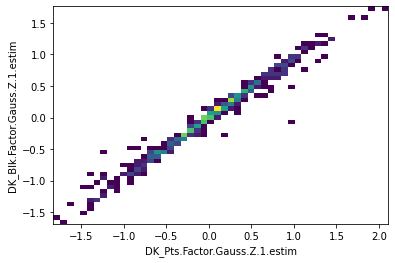

In [42]:
if flagPerformGraphics:
    ax = gp.correlation(blocs, "DK_Pts*1.estim", "DK_Blk*1.estim")

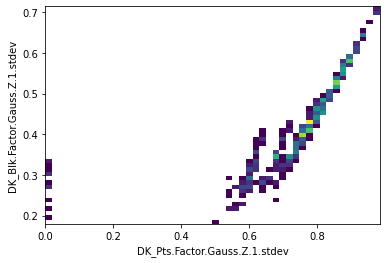

In [43]:
if flagPerformGraphics:
    ax = gp.correlation(blocs, "DK_Pts*1.stdev", "DK_Blk*1.stdev")

Simple Block Kriging over the panel(s)

In [ ]:
ndisc_P = [10,10]
dummy = gl.DisjunctiveKriging(data, panel, model, neigh, gl.EKrigOpt.BLOCK, ndisc_P,
                              True, True, gl.NamingConvention("DK_Blk"))
panel.display()

In [ ]:
axs = gp.grids(panel,names="DK_Blk*estim",figsize=[15,15])

In [ ]:
axs = gp.grids(panel,names="DK_Blk*stdev",figsize=[15,15])

## ===== Uniform Conditioning =====

Calculate the Mean covariance over block

In [ ]:
cvv_Z = model_raw.evalCvv(blocs.getDXs(), ndisc=ndisc_B)

Perform the Point Kriging of the Raw Variable

In [ ]:
data.clearLocators(gl.ELoc.Z)
data.setLocator("Z",gl.ELoc.Z)
dummy = gl.kriging(data, blocs, model, neigh, gl.EKrigOpt.PONCTUAL,
                   True, True, False, gl.VectorInt(), gl.VectorInt(),
                   gl.VectorVectorDouble(), gl.NamingConvention("Z_PTS"))
blocs.display()

In [ ]:
axs = gp.grids(blocs,names="Z_PTS*",figsize=[9,9])

Perform the Uniform Conditioning over Blocks

In [ ]:
dummy = gl.UniformConditioning(blocs, anam, selectivity,
                               "Z_PTS*estim", "Z_PTS*stdev", cvv_Z, False,
                               gl.NamingConvention("UC",False))
blocs.display()
data.setLocator("Gauss.Z",gl.ELoc.Z)

In [ ]:
axs = gp.grids(blocs, "UC.Q*",figsize=[4,4])

In [ ]:
axs = gp.grids(blocs, "UC.T*",figsize=[4,4])

## ===== Block Disjunctive Kriging (DGM-1) =====

Calculate the change of support coefficient

In [ ]:
r1 = anam.evalSupportCoefficient(1, model, blocs.getDXs(), ndisc_B)

Update the Model with Block anamorphosis

In [ ]:
anam_b1 = anam.clone()
anam_b1.setRCoef(r1)

Regularization of the point model by the block support

In [ ]:
vario_b1_Z = gl.Vario_createRegularizeFromModel(model, varioparam, blocs.getDXs(),
                                                 ndisc_B, blocs.getAngles())
cvv = model.evalCvv(blocs.getDXs(), ndisc_B)
vario_b1_Y = gl.Vario_createTransformZToY(vario_b1_Z, anam, cvv)

In [ ]:
if flagPerformGraphics:
    ax = gp.vario(vario_b1_Z)

Fitting the regularized model on the point Gaussian variable

In [ ]:
model_b1_Y = gl.Model(1, ndim)
constraints.setConstantSillValue(1)
dummy = model_b1_Y.fit(vario_b1_Y, gl.ECov.fromValues([4,1]), False,
                       gl.Option_AutoFit(), constraints)

In [ ]:
ax = gp.varmod(vario_b1_Y, model_b1_Y)

Update the Model with Block Anamorphosis

In [ ]:
model_b1_Y.setAnam(anam_b1)
model_b1_Y.display()

Simple Point Kriging over the blocs(s) with Model with Change of Support

In [ ]:
dummy = gl.DisjunctiveKriging(data, blocs, model_b1_Y, neigh, gl.EKrigOpt.PONCTUAL,
                              gl.VectorInt(), True, True,
                              gl.NamingConvention("DK_DGM1"))
blocs.display()

In [ ]:
axs = gp.grids(blocs, names="DK_DGM1*", figsize=[9,9])

Simple Point Kriging over the panel(s) with Model with Change of Support

In [ ]:
dummy = gl.DisjunctiveKriging(data, panel, model_b1_Y, neigh, gl.EKrigOpt.BLOCK,
                              [nx_B, nx_B], True, True,
                              gl.NamingConvention("DK_DGM1"))
panel.display()

In [ ]:
axs = gp.grids(panel, names="DK_DGM1*", figsize=[9,9])

## ===== Block Disjunctive Kriging (DGM-2) =====

Calculate the change of support coefficient

In [ ]:
r2 = anam.evalSupportCoefficient(2, model, blocs.getDXs(), ndisc_B)

Update the Model with Block anamorphosis

In [ ]:
anam_b2 = anam.clone()
anam_b2.setRCoef(r2)

Regularization of the point model by the block support

In [ ]:
vario_b2_Y = gl.Vario_createRegularizeFromModel(model, varioparam, blocs.getDXs(),
                                                ndisc_B, blocs.getAngles())

In [ ]:
ax = gp.vario(vario_b2_Y)

Fitting the regularized model on the point Gaussian variable

In [ ]:
model_b2_Y = gl.Model(1, ndim)
constraints.setConstantSillValue(r2 * r2)
dummy = model_b2_Y.fit(vario_b2_Y, gl.ECov.fromValues([4,1]), False,
                       gl.Option_AutoFit(), constraints)

In [ ]:
ax = gp.varmod(vario_b2_Y, model_b2_Y)

Normalization of the block model to a total sill equal to 1.0

In [ ]:
model_b2_Y.normalize(1.0)
model_b2_Y.display()

In [ ]:
ax = gp.model(model_b2_Y, hmax=vario_b2_Y.getHmax())

Update the Model with Block anamorphosis

In [ ]:
model_b2_Y.setAnam(anam_b2)
model_b2_Y.display()

Simple Point Kriging over the blocs(s) with Model with Change of Support

In [ ]:
dummy = gl.DisjunctiveKriging(data, blocs, model_b2_Y, neigh, gl.EKrigOpt.PONCTUAL,
                              gl.VectorInt(), True, True,
                              gl.NamingConvention("DK_DGM2"))
blocs.display()

In [ ]:
axs = gp.grids(blocs, names="DK_DGM2*", figsize=[9,9])

Simple Point Kriging over the panel(s) with Model with Change of Support

In [ ]:
dummy = gl.DisjunctiveKriging(data, panel, model_b2_Y, neigh, gl.EKrigOpt.BLOCK,
                              [nx_B, nx_B], True, True,
                              gl.NamingConvention("DK_DGM2"))
panel.display()

In [ ]:
axs = gp.grids(panel, names="DK_DGM2*", figsize=[9,9])

## ===== Selectivity Function =====

In [ ]:
gl.FactorToSelectivity(blocs, anam, selectivity, blocs.getNames("DK_Pts*estim"),
                       blocs.getNames("DK_Pts*stdev"), gl.NamingConvention("DK_Pts_Sel", False))
blocs.display()

In [ ]:
axs = gp.grids(blocs, "DK_Pts_Sel.T*",figsize=[4,4])

In [ ]:
axs = gp.grids(blocs, "DK_Pts_Sel.Q*",figsize=[4,4])